In [20]:
results_directory="/private/home/marialomeli/LASER/tasks/bucc/embed"
# load candidate.tsv files and compute precision and recall to plot the P/R curve
# can just run bucc.py with the given file name and collect the output
# we don't need to run for all values of k, we can reuse one of the files 
# with lots of neighbours and select a subset 
powers_of_two = [2**p for p in range(1,8)]
powers_of_two +=[200]
flat =[f"sonar.k{neigh}.bucc2018.de-en.train.candidates.tsv" for neigh in powers_of_two]
flat_diff=[f"sonar_difference.k{neigh}.bucc2018.de-en.train.candidates.tsv" for neigh in powers_of_two]
pq_64 = [f"sonar.margin_ratio.retrieval_max.bucc2018.de-en.PQ64.train.k{neigh}.candidates.tsv" for neigh in powers_of_two]
files = {"flat":flat,"pq64":pq_64}
#files = {"flat":flat}
#files = {"ratio":flat,"difference":flat}
print(files)

{'flat': ['sonar.k2.bucc2018.de-en.train.candidates.tsv', 'sonar.k4.bucc2018.de-en.train.candidates.tsv', 'sonar.k8.bucc2018.de-en.train.candidates.tsv', 'sonar.k16.bucc2018.de-en.train.candidates.tsv', 'sonar.k32.bucc2018.de-en.train.candidates.tsv', 'sonar.k64.bucc2018.de-en.train.candidates.tsv', 'sonar.k128.bucc2018.de-en.train.candidates.tsv', 'sonar.k200.bucc2018.de-en.train.candidates.tsv'], 'pq64': ['sonar.margin_ratio.retrieval_max.bucc2018.de-en.PQ64.train.k2.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.PQ64.train.k4.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.PQ64.train.k8.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.PQ64.train.k16.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.PQ64.train.k32.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.PQ64.train.k64.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.PQ64.train.k128.candidates.tsv', 'sonar.margin_ratio.retr

In [21]:
import subprocess
import itertools
import os
os.chdir("/private/home/marialomeli/LASER/tasks/bucc")
thresholds = {}
precisions= {}
recalls = {}
F1 =  {}
for index_string in files.keys():
    thresholds[index_string]=[]
    precisions[index_string]=[]
    recalls[index_string]=[]
    F1[index_string]=[]
    for filename in files[index_string]:
        command = ['python', 'bucc.py','--src-lang','de','--trg-lang','en','--bucc-texts','./embed/bucc2018.de-en.train.txt','--bucc-ids','./embed/bucc2018.de-en.train.id','--candidates','./embed/'+filename,'--gold','./bucc2018/de-en/de-en.training.gold','--verbose']
        output = subprocess.check_output(command, universal_newlines=True)
        print(filename)
        print(output)
        allbits=output.split('\n')
        helper = [bit.split(',') for bit in allbits[4].split('=')]
        all_metrics = list(itertools.chain.from_iterable(helper))
        thresholds[index_string].append(float(all_metrics[1]))
        precisions[index_string].append(float(all_metrics[3]))
        recalls[index_string].append(float(all_metrics[5]))
        F1[index_string].append(float(all_metrics[7]))

print(thresholds,recalls,precisions,F1)

sonar.k2.bucc2018.de-en.train.candidates.tsv
LASER: tools for BUCC bitext mining
 - reading sentences and IDs
 - reading candidates ./embed/sonar.k2.bucc2018.de-en.train.candidates.tsv
 - optimizing threshold on gold alignments ./bucc2018/de-en/de-en.training.gold
 - best threshold=1.183773, precision=93.21, recall=90.73, F1=91.95

sonar.k4.bucc2018.de-en.train.candidates.tsv
LASER: tools for BUCC bitext mining
 - reading sentences and IDs
 - reading candidates ./embed/sonar.k4.bucc2018.de-en.train.candidates.tsv
 - optimizing threshold on gold alignments ./bucc2018/de-en/de-en.training.gold
 - best threshold=1.352864, precision=93.27, recall=91.12, F1=92.18

sonar.k8.bucc2018.de-en.train.candidates.tsv
LASER: tools for BUCC bitext mining
 - reading sentences and IDs
 - reading candidates ./embed/sonar.k8.bucc2018.de-en.train.candidates.tsv
 - optimizing threshold on gold alignments ./bucc2018/de-en/de-en.training.gold
 - best threshold=1.493512, precision=92.50, recall=91.27, F1=91.88

flat
pq64


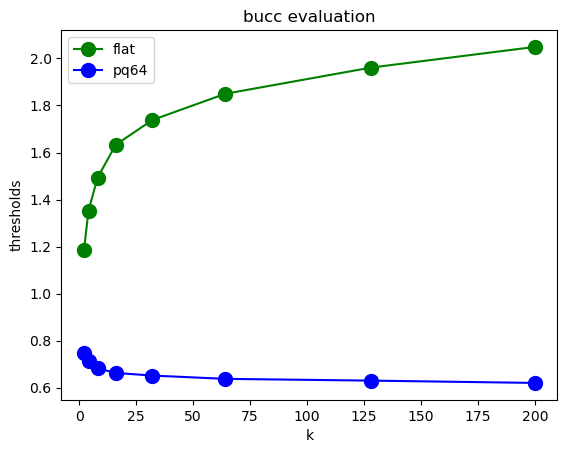

In [23]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ["g", "b", "r", "m", "y", "c"]  #'k' for baseline
index_strings =["ratio","difference"]

for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two, thresholds[file], "o-", markersize=10, color=colors[i], label=file)
#plt.xscale("log")
plt.xlabel("k")
plt.ylabel("thresholds")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

flat
pq64


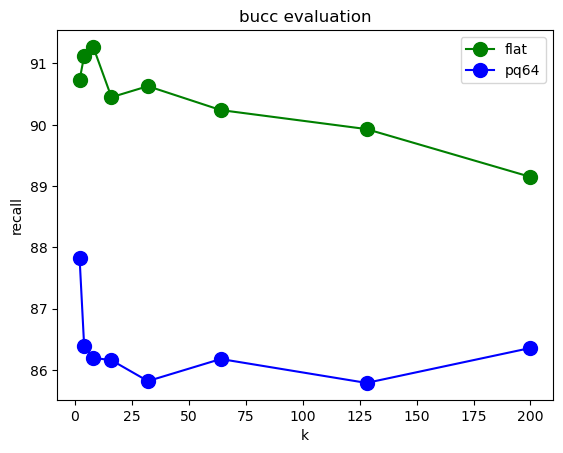

In [25]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ["g", "b", "r", "m", "y", "c"]  #'k' for baseline
for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two, recalls[file], "o-", markersize=10, color=colors[i], label=file)

    #plt.plot(powers_of_two,recalls["ratio"], "o-", markersize=10, color=colors[2],label=index_strings[0])
#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("recall")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

flat
pq64


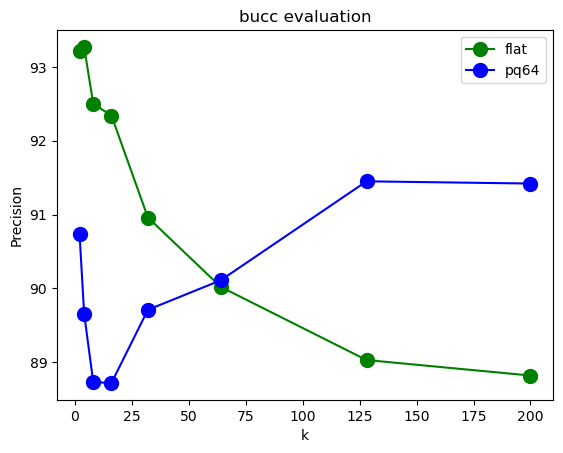

In [26]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ["g", "b", "r", "m", "y", "c"]  #'k' for baseline
for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two,precisions[file], "o-", markersize=10, color=colors[i],label=file)
#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("Precision")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

flat
pq64


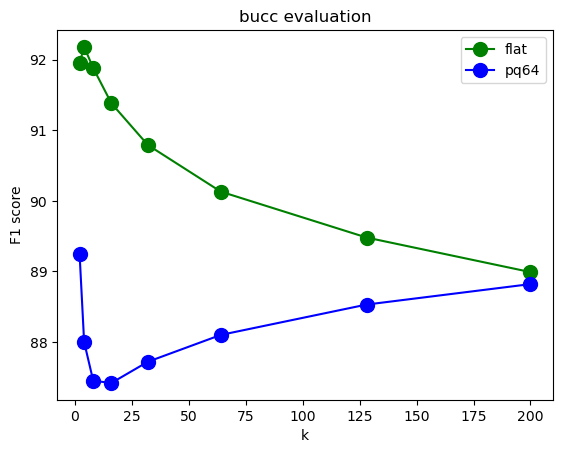

In [27]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ["g", "b", "r", "m", "y", "c"]  #'k' for baseline

for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two,F1[file], "o-", markersize=10, color=colors[i],label=file)

#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("F1 score")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

In [ ]:
# PR curve for each threshold for each k, see BuccOptimize for collecting this